In [292]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
folder_path = 'mouseTrackingData'

csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
dataframes = [pd.read_csv(file) for file in csv_files]
# filenames = [os.path.basename(file) for file in csv_files]


In [293]:
block_pairs = [(1, 2), (3, 4), (5, 6), (7, 8)]
all_blocks = {f"{a}_{b}": [] for a, b in block_pairs}

for df in dataframes:
    df = df[df['phase'] != 'waitingForTarget']  # Phase-Filter
    for a, b in block_pairs:
        df_block = df[df['round'].isin([a, b])].reset_index(drop=True)
        all_blocks[f"{a}_{b}"].append(df_block)

In [294]:
grouped_blocks = {
    '1_2': [],
    '3_4': [],
    '5_6': [],
    '7_8': []
}

for key in grouped_blocks.keys():
    for df in all_blocks[key]:
        df_grouped = df.groupby(['round', 'trial']).agg({
            'timestamp': list,
            'mouse_x': list,
            'mouse_y': list,
            'version': 'first',
            'id': 'first'
        }).reset_index()
        grouped_blocks[key].append(df_grouped)


In [295]:
grouped_df_1_2 = grouped_blocks["1_2"]
grouped_df_3_4 = grouped_blocks["3_4"]
grouped_df_5_6 = grouped_blocks["5_6"]
grouped_df_7_8 = grouped_blocks["7_8"]

In [296]:
len(grouped_df_1_2)

50

In [297]:
def normalize_positions(row):
    # Normalisieren (Startpunkt auf 0,0 setzen)
    x_positions = np.array(row["mouse_x"])
    y_positions = np.array(row["mouse_y"])
    
    x_start, y_start = x_positions[0], y_positions[0]
    x_norm = x_positions - x_start
    y_norm = y_positions - y_start

    row["mouse_x"] = x_norm
    row["mouse_y"] = y_norm

    return row


In [298]:
grouped_dfs = {
    '1_2': grouped_df_1_2,
    '3_4': grouped_df_3_4,
    '5_6': grouped_df_5_6,
    '7_8': grouped_df_7_8
}

processed_dfs = {}

for key, df_list in grouped_dfs.items():
    processed_dfs[key] = [df.apply(normalize_positions, axis=1) for df in df_list]


In [299]:
processed_dfs

{'1_2': [     round  trial                                          timestamp  \
  0        1      1  [14:14:14.373, 14:14:14.390, 14:14:14.409, 14:...   
  1        1      2  [14:14:18.273, 14:14:18.289, 14:14:18.307, 14:...   
  2        1      3  [14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...   
  3        1      4  [14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...   
  4        1      5  [14:14:30.040, 14:14:30.056, 14:14:30.073, 14:...   
  ..     ...    ...                                                ...   
  115      2     56  [14:21:05.375, 14:21:05.389, 14:21:05.410, 14:...   
  116      2     57  [14:21:08.561, 14:21:08.573, 14:21:08.590, 14:...   
  117      2     58  [14:21:11.806, 14:21:11.823, 14:21:11.841, 14:...   
  118      2     59  [14:21:14.840, 14:21:14.856, 14:21:14.874, 14:...   
  119      2     60  [14:21:17.540, 14:21:17.558, 14:21:17.572, 14:...   
  
                                                 mouse_x  \
  0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [300]:
def calculate_euclidean_distances(row):
    x = row['mouse_x']
    y = row['mouse_y']
    dx = np.diff(x)
    dy = np.diff(y)
    dist = np.sqrt(dx**2 + dy**2)
    return np.insert(dist, 0, 0.0)  # Schrittweiten, erste ist 0


In [301]:
def is_valid_array(val):
    import numpy as np
    if not isinstance(val, np.ndarray):
        return False
    try:
        return len(val) > 1
    except TypeError:
        return False

processed_dataframes_clean = {}

for key, df_list in processed_dfs.items():
    cleaned_list = []
    for df in df_list:
        df_clean = df[df.apply(
            lambda row: is_valid_array(row['mouse_x']) and is_valid_array(row['mouse_y']),
            axis=1
        )]
        cleaned_list.append(df_clean)
    processed_dataframes_clean[key] = cleaned_list

In [302]:
len(processed_dataframes_clean["1_2"])

50

In [303]:
for key, df_list in processed_dataframes_clean.items():
    print(key)

1_2
3_4
5_6
7_8


In [304]:
for key, df_list in processed_dataframes_clean.items():
    for i, df in enumerate(df_list):
        df = df.copy()
        df['euk_dist'] = df.apply(calculate_euclidean_distances, axis=1)
        df_list[i] = df


In [305]:
processed_dataframes_clean["1_2"][0]

,round,trial,timestamp,mouse_x,mouse_y,version,id,euk_dist
0,1,1,"[14:14:14.373, 14:14:14.390, 14:14:14.409, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2,"[14:14:18.273, 14:14:18.289, 14:14:18.307, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3,"[14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...","[0.0, 0.0, -0.010999999999999982, -0.014999999...","[0.0, 0.0, -0.012, -0.015, -0.017, -0.017, -0....",lld,1085,"[0.0, 0.0, 0.016278820596099693, 0.00500000000..."
3,1,4,"[14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...","[0.0, 0.023, 0.031, 0.033, 0.05699999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.011999999999...",lld,1085,"[0.0, 0.023, 0.008, 0.0020000000000000018, 0.0..."
4,1,5,"[14:14:30.040, 14:14:30.056, 14:14:30.073, 14:...","[0.0, 0.0, 0.0, 0.010999999999999996, 0.015, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.010999999999999996, 0.004000..."
...,...,...,...,...,...,...,...,...
115,2,56,"[14:21:05.375, 14:21:05.389, 14:21:05.410, 14:...","[0.0, 0.04799999999999999, 0.07600000000000001...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.04799999999999999, 0.02800000000000002..."
116,2,57,"[14:21:08.561, 14:21:08.573, 14:21:08.590, 14:...","[0.0, -0.03299999999999992, -0.044000000000000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.03299999999999992, 0.01100000000000012..."
117,2,58,"[14:21:11.806, 14:21:11.823, 14:21:11.841, 14:...","[0.0, -0.05700000000000005, -0.144000000000000...","[0.0, -0.01200000000000001, -0.016000000000000...",lld,1085,"[0.0, 0.05824946351684285, 0.08709190547921199..."
118,2,59,"[14:21:14.840, 14:21:14.856, 14:21:14.874, 14:...","[0.0, -0.318, -0.863, -1.4660000000000002, -1....","[0.0, -0.055999999999999994, -0.07600000000000...",lld,1085,"[0.0, 0.322893171188243, 0.5453668490108287, 0..."


In [306]:
import pandas as pd
import numpy as np
from datetime import datetime

def calculate_speed(row, window_ms=50):
    timestamps = row['timestamp']  # Liste von Strings, z.B. ['14:14:14.373', '14:14:14.390', ...]
    euk_dist = row['euk_dist']     # Array von Distanzen zwischen aufeinanderfolgenden Messpunkten

    # 1. Timestamps in datetime-Objekte umwandeln (nur Zeit, ohne Datum)
    times = [datetime.strptime(ts, '%H:%M:%S.%f') for ts in timestamps]

    # 2. Zeitdifferenzen in Millisekunden zum Startzeitpunkt berechnen
    start_time = times[0]
    elapsed_ms = np.array([(t - start_time).total_seconds() * 1000 for t in times])

    # 3. Fenster-IDs zuweisen (jeder Zeitstempel kommt in ein Fenster von 0-5ms, 5-10ms, ...)
    window_ids = (elapsed_ms // window_ms).astype(int)
    if len(window_ids) > 1000:
        print(window_ids)
    # 4. Für jedes Fenster die Summe der euklidischen Distanzen berechnen
    # Achtung: euk_dist hat vermutlich eine Länge = len(timestamps), evtl. Off-by-One, 
    # falls euk_dist Distanzen zwischen Messpunkten sind, dann hat euk_dist = len(timestamps) - 1
    # Darum passen wir window_ids an:
    if len(euk_dist) == len(timestamps):
        dist_to_sum = np.array(euk_dist)
    elif len(euk_dist) == len(timestamps) - 1:
        dist_to_sum = np.array(euk_dist)
        window_ids = window_ids[:-1]  # letztes Zeitfenster fällt raus, weil keine Distanz danach
    else:
        raise ValueError("Längen von timestamps und euk_dist passen nicht zusammen")

    # Summe pro Fenster
    import collections
    dist_per_window = collections.defaultdict(float)
    for w_id, dist in zip(window_ids, dist_to_sum):
        dist_per_window[w_id] += dist

    # 5. Geschwindigkeit pro Fenster = Distanz / Zeit (Zeit = window_ms ms = window_ms / 1000 s)
    speed_per_window = {w: dist / (window_ms / 1000) for w, dist in dist_per_window.items()}

    # 6. Optional: Ergebnis als Liste zurückgeben, sortiert nach Fenster-ID
    max_window = max(window_ids)
    speeds = [speed_per_window.get(i, 0) for i in range(max_window + 1)]

    return speeds


In [307]:
for key, df_list in processed_dataframes_clean.items():
    for i, df in enumerate(df_list):
        df = df.copy()  # sicherheitshalber
        df['speed'] = df.apply(calculate_speed, axis=1)
        df_list[i] = df


In [308]:
processed_dataframes_clean["1_2"][0]["speed"][0]

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(9.819999999999999),
 np.float64(20.720047618777677),
 np.float64(3.500000000000001),
 np.float64(5.365810759733823),
 np.float64(6.103559294187546),
 np.float64(1.117357268520612),
 np.float64(0.05656854249492071),
 np.float64(0.0),
 np.float64(0.4800000000000004),
 np.float64(1.8001785571952416),
 np.float64(2.2199999999999953),
 np.float64(0.8400000000000052),
 np.float64(0.019999999999997797),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0)]

In [309]:
df_lld = {}
df_rld = {}

for key, df_list in processed_dataframes_clean.items():
    df_lld[key] = []
    df_rld[key] = []
    
    for df in df_list:
        version = df.iloc[0]['version']
        if version == 'lld':
            df_lld[key].append(df)
        elif version == 'rld':
            df_rld[key].append(df)


In [310]:
df_lld["1_2"][0]

,round,trial,timestamp,mouse_x,mouse_y,version,id,euk_dist,speed
0,1,1,"[14:14:14.373, 14:14:14.390, 14:14:14.409, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.8199999999999..."
1,1,2,"[14:14:18.273, 14:14:18.289, 14:14:18.307, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 9.63311011058294, 19..."
2,1,3,"[14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...","[0.0, 0.0, -0.010999999999999982, -0.014999999...","[0.0, 0.0, -0.012, -0.015, -0.017, -0.017, -0....",lld,1085,"[0.0, 0.0, 0.016278820596099693, 0.00500000000...","[0.42557641192199386, 0.06472135954999586, 0.5..."
3,1,4,"[14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...","[0.0, 0.023, 0.031, 0.033, 0.05699999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.011999999999...",lld,1085,"[0.0, 0.023, 0.008, 0.0020000000000000018, 0.0...","[0.62, 0.66, 1.9134764835351092, 2.56011147510..."
4,1,5,"[14:14:30.040, 14:14:30.056, 14:14:30.073, 14:...","[0.0, 0.0, 0.0, 0.010999999999999996, 0.015, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.010999999999999996, 0.004000...","[0.21999999999999992, 0.11999999999999983, 0.0..."
...,...,...,...,...,...,...,...,...,...
115,2,56,"[14:21:05.375, 14:21:05.389, 14:21:05.410, 14:...","[0.0, 0.04799999999999999, 0.07600000000000001...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.04799999999999999, 0.02800000000000002...","[2.6, 4.3, 1.279999999999999, 0.50043457732885..."
116,2,57,"[14:21:08.561, 14:21:08.573, 14:21:08.590, 14:...","[0.0, -0.03299999999999992, -0.044000000000000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.03299999999999992, 0.01100000000000012...","[0.9600000000000009, 0.019999999999997797, 0.0..."
117,2,58,"[14:21:11.806, 14:21:11.823, 14:21:11.841, 14:...","[0.0, -0.05700000000000005, -0.144000000000000...","[0.0, -0.01200000000000001, -0.016000000000000...",lld,1085,"[0.0, 0.05824946351684285, 0.08709190547921199...","[2.906827379921096, 7.4201493909090805, 0.2199..."
118,2,59,"[14:21:14.840, 14:21:14.856, 14:21:14.874, 14:...","[0.0, -0.318, -0.863, -1.4660000000000002, -1....","[0.0, -0.055999999999999994, -0.07600000000000...",lld,1085,"[0.0, 0.322893171188243, 0.5453668490108287, 0...","[17.365200403981433, 28.34394177384505, 7.7586..."


In [311]:
def get_target_pos(row):
    last_x = row['mouse_x'][-1]
    return 'r' if last_x > 0 else 'l'

df['targetPos'] = df.apply(get_target_pos, axis=1)

In [312]:
for key, df_list in df_lld.items():
    print(key)
    for i, df in enumerate(df_list):
        target_pos_series = df.apply(get_target_pos, axis=1)
        df_lld[key][i] = df.copy() 
        df_lld[key][i]['targetPos'] = target_pos_series

1_2
3_4
5_6
7_8


In [313]:
for key, df_list in df_rld.items():
    print(key)
    for i, df in enumerate(df_list):
        target_pos_series = df.apply(get_target_pos, axis=1)
        df_rld[key][i] = df.copy() 
        df_rld[key][i]['targetPos'] = target_pos_series

1_2
3_4
5_6
7_8


In [314]:
# l und r in left condition aufteilen

df_lld_left_target = {}
df_lld_right_target = {}

for key, df_list in df_lld.items():
    df_lld_left_target[key] = []
    df_lld_right_target[key] = []
    
    for df in df_list:
        df_left = df[df['targetPos'] == 'l'].reset_index(drop=True)
        df_right = df[df['targetPos'] == 'r'].reset_index(drop=True)
        
        df_lld_left_target[key].append(df_left)
        df_lld_right_target[key].append(df_right)


In [315]:
len(df_lld_left_target["1_2"][0])

60

In [316]:
# l und r in right condition aufteilen

df_rld_left_target = {}
df_rld_right_target = {}

for key, df_list in df_rld.items():
    df_rld_left_target[key] = []
    df_rld_right_target[key] = []
    
    for df in df_list:
        df_left = df[df['targetPos'] == 'l'].reset_index(drop=True)
        df_right = df[df['targetPos'] == 'r'].reset_index(drop=True)
        
        df_rld_left_target[key].append(df_left)
        df_rld_right_target[key].append(df_right)


In [317]:
target_time_ms = np.arange(0, 4000 + 1, 50)  # 801 Punkte
print(len(target_time_ms))
avg_speed_per_participant_lld_left_78 = []

for df in df_lld_left_target["7_8"]:
    aligned_speeds = []

    for speed in df['speed']:
        aligned_speed = np.zeros(len(target_time_ms))  # Array mit 0 initialisieren
        
        if len(speed) > len(target_time_ms):
            speed = speed[:len(target_time_ms)]
        n_points = len(speed)
        aligned_speed[:n_points] = speed  # Originalwerte an den Anfang schreiben
        
        aligned_speeds.append(aligned_speed)

    speed_matrix = np.vstack(aligned_speeds)
    mean_speed = np.mean(speed_matrix, axis=0)  # Mittelwert berechnen (keine NaNs)
    avg_speed_per_participant_lld_left_78.append(mean_speed)


81


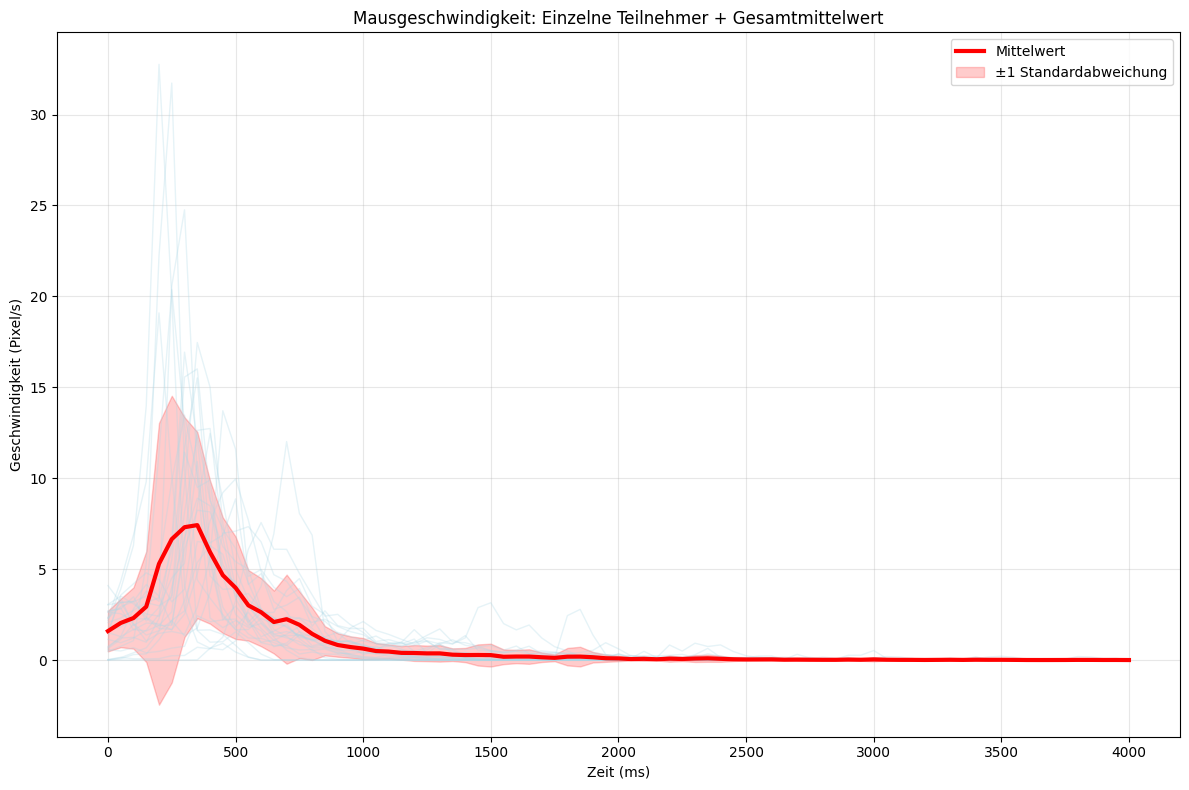

In [318]:
plt.figure(figsize=(12, 8))

# Alle Teilnehmer als transparente Linien
for i, speed_data in enumerate(avg_speed_per_participant_lld_left_78):
    plt.plot(target_time_ms, speed_data, color='lightblue', alpha=0.3, linewidth=1)

# Gesamtmittelwert berechnen und hervorheben
all_speeds = np.array(avg_speed_per_participant_lld_left_78)
mean_speed = np.mean(all_speeds, axis=0)
std_speed = np.std(all_speeds, axis=0)

plt.plot(target_time_ms, mean_speed, color='red', linewidth=3, label='Mittelwert')
plt.fill_between(target_time_ms, 
                 mean_speed - std_speed, 
                 mean_speed + std_speed, 
                 alpha=0.2, color='red', label='±1 Standardabweichung')

plt.xlabel('Zeit (ms)')
plt.ylabel('Geschwindigkeit (Pixel/s)')
plt.title('Mausgeschwindigkeit: Einzelne Teilnehmer + Gesamtmittelwert')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [319]:
# Umwandeln in (n_personen x 801) Matrix
group_matrix_78 = np.vstack(avg_speed_per_participant_lld_left_78)

# Mittelwert über Personen hinweg (Achse 0)
mean_speed_lld_left_78 = np.nanmean(group_matrix_78, axis=0)


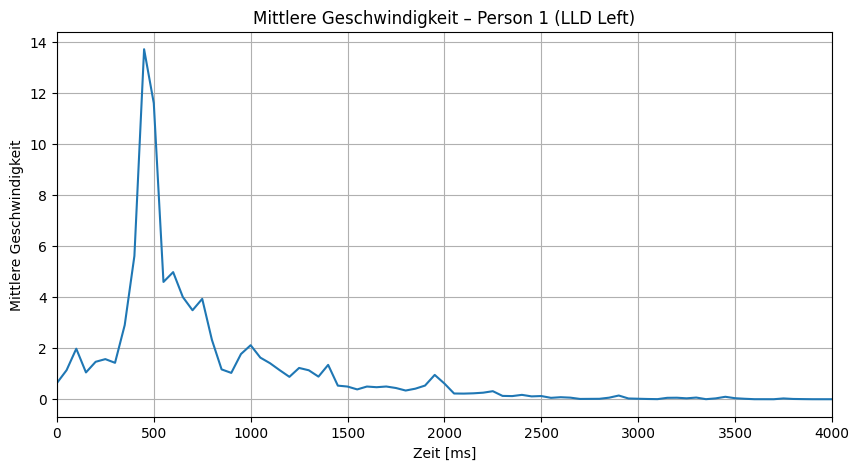

In [320]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(target_time_ms, avg_speed_per_participant_lld_left_78[1])
plt.xlabel("Zeit [ms]")
plt.ylabel("Mittlere Geschwindigkeit")
plt.title("Mittlere Geschwindigkeit – Person 1 (LLD Left)")
plt.xlim(0, 4000)
plt.grid(True)
plt.show()


In [321]:
target_time_ms = np.arange(0, 4000 + 1, 50)  # 801 Punkte

avg_speed_per_participant_lld_left_12 = []

for df in df_lld_left_target["1_2"]:
    aligned_speeds = []

    for speed in df['speed']:
        print(speed[1])
        aligned_speed = np.zeros(len(target_time_ms))  # Array mit 0 initialisieren
        
        if len(speed) > len(target_time_ms):
            speed = speed[:len(target_time_ms)]
        n_points = len(speed)
        aligned_speed[:n_points] = speed  # Originalwerte an den Anfang schreiben
        
        aligned_speeds.append(aligned_speed)

    speed_matrix = np.vstack(aligned_speeds)
    mean_speed = np.mean(speed_matrix, axis=0)  # Mittelwert berechnen (keine NaNs)
    avg_speed_per_participant_lld_left_12.append(mean_speed)


0.0
0.06472135954999586
0.66
4.907920264880823
7.275930416401352
0.06000000000000005
0.0
1.6655275385478263
0.08000000000000007
3.458830657713724
1.5094906471322316
1.7495163743996682
1.9090892093771763
2.819035399537718
1.5512882635562808
0.10246211251235109
2.1796119780585
0.06472135954999808
6.399970516208302
2.9000000000000004
2.482687526114482
1.1452928315921218
1.4408107243515549
1.8823133037808693
0.940000000000003
0.0
1.9723409538593728
4.000303082471676
4.2400482230098735
4.640225001908895
0.2400000000000002
4.700061349115996
4.963995112872919
8.443265154033345
8.800120205122616
2.821317493064346
3.480294054067797
0.0
2.26
3.1369087803395095
1.5796682809845835
0.5832612114233756
0.0
0.8804996878900142
0.5200000000000005
4.680161279834199
2.5691517133165713
0.21798989873223348
6.520317368928998
1.1399999999999988
1.585653892077692
1.6611383396523582
1.3200000000000012
0.36000000000000476
2.0049513114372943
0.020000000000002238
5.680000000000001
4.3
7.4201493909090805
28.3439417

In [322]:
# Umwandeln in (n_personen x 801) Matrix
group_matrix_12 = np.vstack(avg_speed_per_participant_lld_left_12)

# Mittelwert über Personen hinweg (Achse 0)
mean_speed_lld_left_12 = np.nanmean(group_matrix_12, axis=0)


In [323]:
avg_speed_per_participant_lld_left_12

[array([3.65096244e+00, 2.87224973e+00, 2.33374914e+00, 2.08806906e+00,
        2.22442702e+00, 7.12926374e+00, 1.73275793e+01, 1.68367917e+01,
        9.53725453e+00, 5.41464768e+00, 3.19924817e+00, 2.31160566e+00,
        3.06352162e+00, 3.18401598e+00, 4.16295626e+00, 3.49413754e+00,
        2.35834708e+00, 1.83790460e+00, 1.59534811e+00, 9.15239413e-01,
        6.34208282e-01, 4.00278964e-01, 3.66288042e-01, 5.15334267e-01,
        4.03573465e-01, 2.00220590e-01, 6.30480729e-02, 1.61226315e-01,
        1.27629572e-01, 9.70622485e-02, 7.93524262e-02, 1.40993629e-01,
        7.55024269e-02, 6.42954356e-03, 4.71404521e-04, 0.00000000e+00,
        5.66666667e-03, 7.54247233e-03, 8.04737854e-04, 3.33333333e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

### Vergleich der Durschnittsgeschwindigkeiten über Zeit zwischen lld left von block 1-2 und 7-8 (78 ist am anfang nach der initierung langsamer)

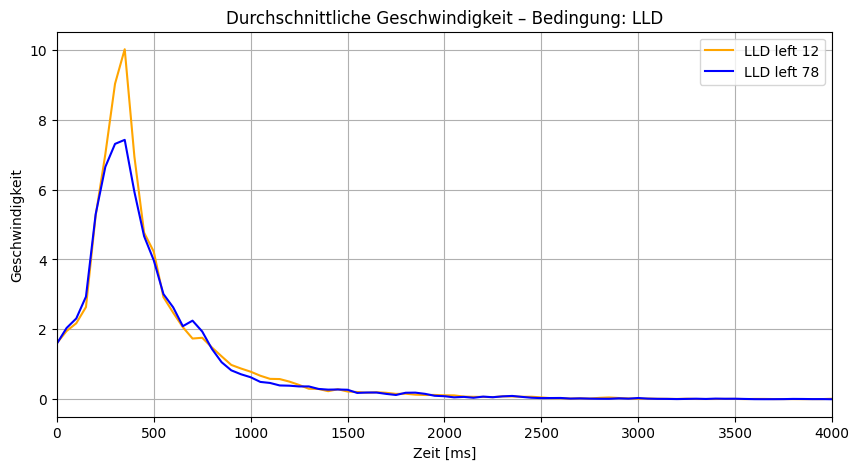

In [332]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Linie + Punkte (standardmäßig verbunden)
plt.plot(target_time_ms, mean_speed_lld_left_12,
         color='orange', label='LLD left 12', linestyle='-')

plt.plot(target_time_ms, mean_speed_lld_left_78,
         color='blue', label='LLD left 78', linestyle='-')

plt.xlabel("Zeit [ms]")
plt.ylabel("Geschwindigkeit")
plt.title("Durchschnittliche Geschwindigkeit – Bedingung: LLD")
plt.xlim(0, 4000)
plt.grid(True)
plt.legend()
plt.show()


In [344]:
target_time_ms = np.arange(0, 4000 + 1, 50)  # 801 Punkte
print(len(target_time_ms))
avg_speed_per_participant_lld_right_78 = []

for df in df_lld_right_target["7_8"]:
    aligned_speeds = []

    for speed in df['speed']:
        aligned_speed = np.zeros(len(target_time_ms))  # Array mit 0 initialisieren
        
        if len(speed) > len(target_time_ms):
            speed = speed[:len(target_time_ms)]
        n_points = len(speed)
        aligned_speed[:n_points] = speed  # Originalwerte an den Anfang schreiben
        
        aligned_speeds.append(aligned_speed)

    speed_matrix = np.vstack(aligned_speeds)
    mean_speed = np.mean(speed_matrix, axis=0)  # Mittelwert berechnen (keine NaNs)
    avg_speed_per_participant_lld_right_78.append(mean_speed)

81


In [345]:
# Umwandeln in (n_personen x 801) Matrix
group_matrix_lld_right_78 = np.vstack(avg_speed_per_participant_lld_right_78)

# Mittelwert über Personen hinweg (Achse 0)
mean_speed_lld_right_78 = np.nanmean(group_matrix_lld_right_78, axis=0)

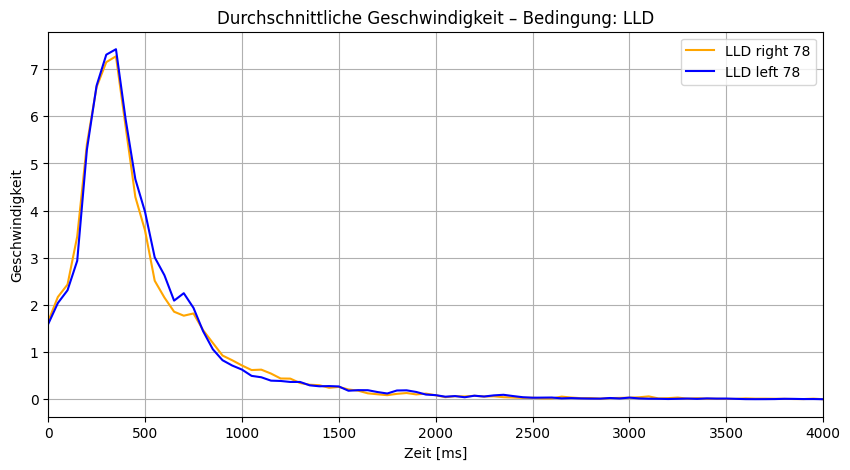

In [346]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Linie + Punkte (standardmäßig verbunden)
plt.plot(target_time_ms, mean_speed_lld_right_78,
         color='orange', label='LLD right 78', linestyle='-')

plt.plot(target_time_ms, mean_speed_lld_left_78,
         color='blue', label='LLD left 78', linestyle='-')

plt.xlabel("Zeit [ms]")
plt.ylabel("Geschwindigkeit")
plt.title("Durchschnittliche Geschwindigkeit – Bedingung: LLD")
plt.xlim(0, 4000)
plt.grid(True)
plt.legend()
plt.show()